<a href="https://colab.research.google.com/github/Nehasatheesh04/Deep_Learning/blob/main/DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GAN_MNIST

In [ ]:
pip install torch torchvision matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
img_shape = 28 * 28
batch_size = 128
epochs = 50
lr = 0.0002

# Transform for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, img_shape),
            nn.Tanh()  # Output values between -1 and 1
        )

    def forward(self, z):
        img = self.model(z)
        return img

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_shape, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss
adversarial_loss = nn.BCELoss()

# Directory for saving samples
os.makedirs("images", exist_ok=True)

def save_generated_images(epoch, generator, fixed_noise):
    generator.eval()
    with torch.no_grad():
        gen_imgs = generator(fixed_noise).reshape(-1, 1, 28, 28)
        gen_imgs = gen_imgs * 0.5 + 0.5  # Denormalize to [0,1]
        grid = torchvision.utils.make_grid(gen_imgs[:25], nrow=5)
        npimg = grid.cpu().numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(f'Epoch {epoch}')
        plt.axis('off')
        plt.savefig(f'images/epoch_{epoch}.png')
        plt.close()

# Fixed noise for consistent image generation
fixed_noise = torch.randn(25, latent_dim).to(device)

# Training loop
for epoch in range(1, epochs + 1):
    for i, (imgs, _) in enumerate(train_loader):
        real_imgs = imgs.view(imgs.size(0), -1).to(device)
        real_labels = torch.ones(imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(imgs.size(0), 1).to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        generated_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(generated_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), real_labels)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        if i % 200 == 0:
            print(f"Epoch [{epoch}/{epochs}] Batch {i}/{len(train_loader)} \
                  Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")

    # Save sample images
    save_generated_images(epoch, generator, fixed_noise)


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 510kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.95MB/s]


Epoch [1/50] Batch 0/469                   Loss D: 0.7106, Loss G: 0.6589
Epoch [1/50] Batch 200/469                   Loss D: 0.6826, Loss G: 0.3831
Epoch [1/50] Batch 400/469                   Loss D: 0.2527, Loss G: 1.9538
Epoch [2/50] Batch 0/469                   Loss D: 0.2065, Loss G: 1.5228
Epoch [2/50] Batch 200/469                   Loss D: 0.6643, Loss G: 0.3273
Epoch [2/50] Batch 400/469                   Loss D: 0.1327, Loss G: 1.8566
Epoch [3/50] Batch 0/469                   Loss D: 0.5242, Loss G: 4.0002
Epoch [3/50] Batch 200/469                   Loss D: 0.0793, Loss G: 3.9626
Epoch [3/50] Batch 400/469                   Loss D: 0.0467, Loss G: 4.0845
Epoch [4/50] Batch 0/469                   Loss D: 0.2515, Loss G: 1.5327
Epoch [4/50] Batch 200/469                   Loss D: 0.1614, Loss G: 1.7128
Epoch [4/50] Batch 400/469                   Loss D: 0.1650, Loss G: 1.9761
Epoch [5/50] Batch 0/469                   Loss D: 0.1679, Loss G: 3.4195
Epoch [5/50] Batch 200

Displaying image from Epoch 1:


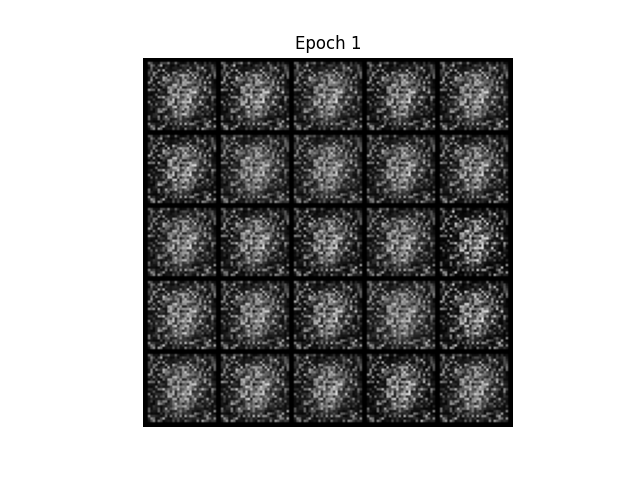

Displaying image from Epoch 10:


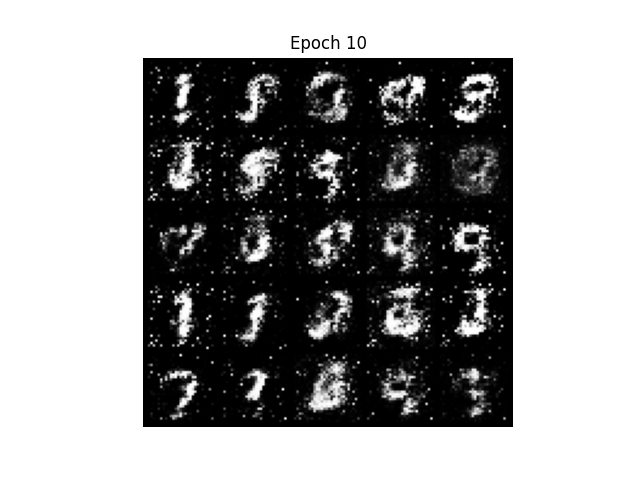

Displaying image from Epoch 20:


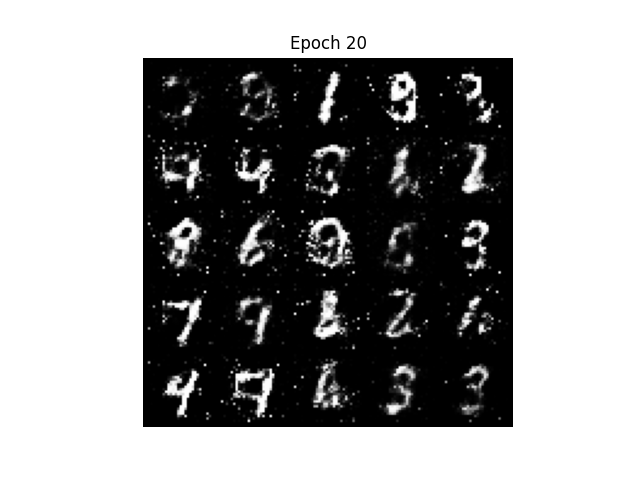

Displaying image from Epoch 30:


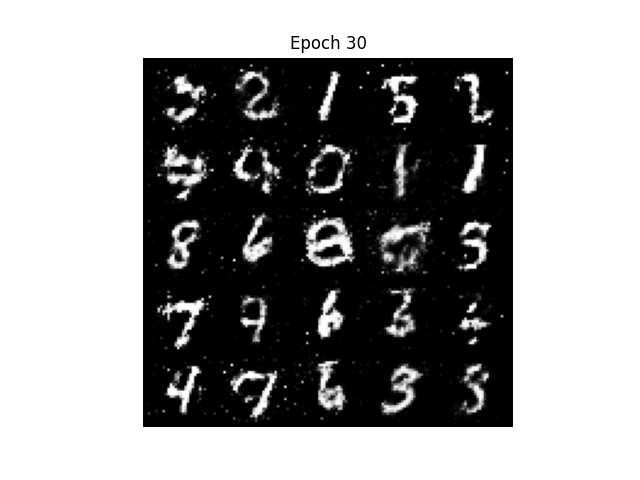

Displaying image from Epoch 40:


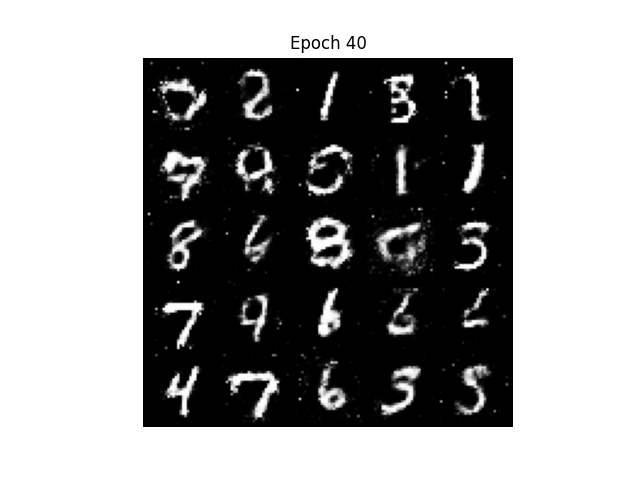

Displaying image from Epoch 50:


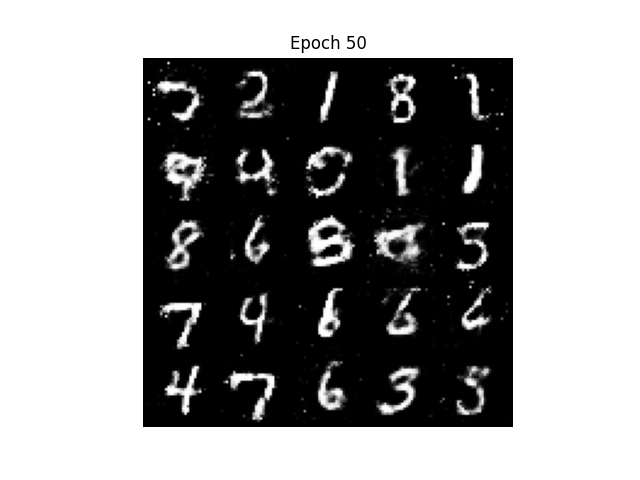

In [ ]:
from IPython.display import Image, display
import os

image_dir = 'images'
epochs_to_display = [1, 10, 20,30,40, 50]

for epoch in epochs_to_display:
    image_path = os.path.join(image_dir, f'epoch_{epoch}.png')
    if os.path.exists(image_path):
        print(f"Displaying image from Epoch {epoch}:")
        display(Image(filename=image_path))
    else:
        print(f"Image for Epoch {epoch} not found at {image_path}")

Dimensionality reduction using t-SNE,LLE,UMAP,Isomap


Original dataset shape: (1797, 64)


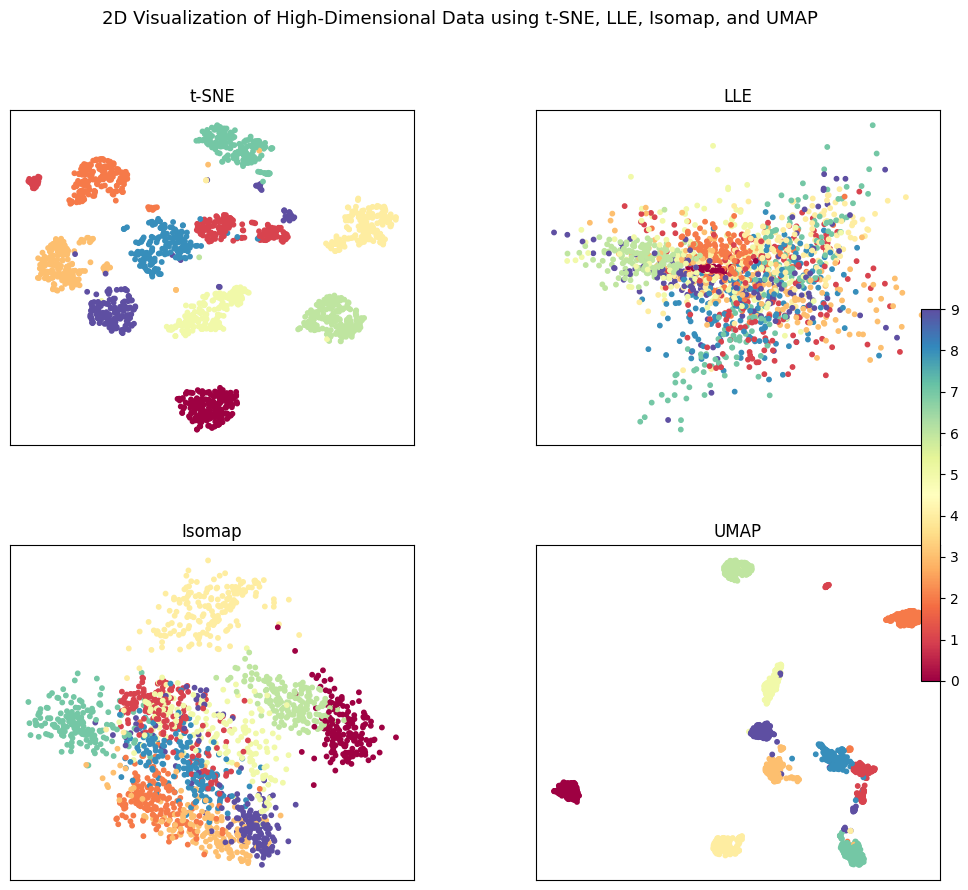

In [5]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap
import umap.umap_ as umap

# Load dataset (64 features per image)
digits = datasets.load_digits()
X, y = digits.data, digits.target
print("Original dataset shape:", X.shape)

# Dimensionality reduction methods
X_tsne   = TSNE(n_components=2, random_state=42).fit_transform(X)
X_lle    = LocallyLinearEmbedding(n_components=2, n_neighbors=30).fit_transform(X)
X_isomap = Isomap(n_components=2, n_neighbors=30).fit_transform(X)
X_umap   = umap.UMAP(n_components=2, n_neighbors=30).fit_transform(X)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
methods = ['t-SNE', 'LLE', 'Isomap', 'UMAP']
embeddings = [X_tsne, X_lle, X_isomap, X_umap]

for ax, method, emb in zip(axes.ravel(), methods, embeddings):
    sc = ax.scatter(emb[:, 0], emb[:, 1], c=y, cmap='Spectral', s=10)
    ax.set_title(method)
    ax.set_xticks([])
    ax.set_yticks([])
fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
plt.suptitle("2D Visualization of High-Dimensional Data using t-SNE, LLE, Isomap, and UMAP", fontsize=13)
plt.subplots_adjust(wspace=0.3, hspace=0.3, right=0.9)
plt.show()


RBM

In [11]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [12]:
# 1️⃣ Load and preprocess a small dataset (Binarized MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x > 0.5).float()  # Binarize pixels (0 or 1)
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
#  Define a simple RBM model with binary visible & hidden units
class RBM(nn.Module):
    def __init__(self, n_visible=784, n_hidden=128):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.1)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))

    def sample_prob(self, probs):
        return torch.bernoulli(probs)

    def v_to_h(self, v):
        p_h = torch.sigmoid(torch.matmul(v, self.W.t()) + self.h_bias)
        return p_h, self.sample_prob(p_h)

    def h_to_v(self, h):
        p_v = torch.sigmoid(torch.matmul(h, self.W) + self.v_bias)
        return p_v, self.sample_prob(p_v)



In [13]:
# Train the RBM using Contrastive Divergence
rbm = RBM()
lr = 0.1
epochs = 5
recon_errors = []

for epoch in range(epochs):
    epoch_error = 0
    for batch, _ in train_loader:
        v0 = batch.view(-1, 784)
        ph0, h0 = rbm.v_to_h(v0)
        pvk, vk = rbm.h_to_v(h0)
        phk, hk = rbm.v_to_h(vk)

        # Update weights and biases (CD-1)
        rbm.W.data += lr * ((torch.matmul(ph0.t(), v0) - torch.matmul(phk.t(), vk)) / v0.size(0))
        rbm.v_bias.data += lr * torch.mean(v0 - vk, dim=0)
        rbm.h_bias.data += lr * torch.mean(ph0 - phk, dim=0)

        # Reconstruction error for this batch
        batch_error = torch.mean((v0 - vk) ** 2)
        epoch_error += batch_error.item()

    avg_error = epoch_error / len(train_loader)
    recon_errors.append(avg_error)
    print(f"Epoch {epoch+1}/{epochs} | Reconstruction Error: {avg_error:.4f}")

Epoch 1/5 | Reconstruction Error: 0.0931
Epoch 2/5 | Reconstruction Error: 0.0695
Epoch 3/5 | Reconstruction Error: 0.0633
Epoch 4/5 | Reconstruction Error: 0.0596
Epoch 5/5 | Reconstruction Error: 0.0571


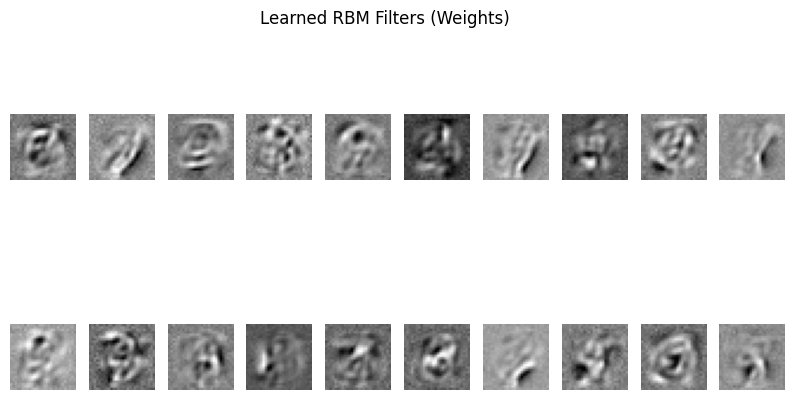

In [14]:
# Visualize the learned weights (filters)
with torch.no_grad():
    plt.figure(figsize=(10, 5))
    for i in range(20):
        plt.subplot(2, 10, i + 1)
        plt.imshow(rbm.W[i].view(28, 28).detach().numpy(), cmap='gray')
        plt.axis('off')
    plt.suptitle("Learned RBM Filters (Weights)")
    plt.show()

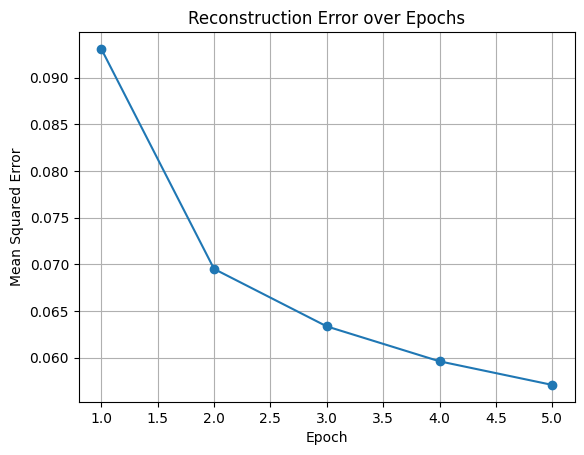

In [15]:
# Plot how reconstruction error changes as training progresses
plt.plot(range(1, epochs + 1), recon_errors, marker='o')
plt.title("Reconstruction Error over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.grid(True)
plt.show()

In [16]:
#Use the trained RBM to reconstruct inputs
data_iter = iter(train_loader)
images, _ = next(data_iter)
v = images.view(-1, 784)

with torch.no_grad():
    v_reconstructed = rbm.h_to_v(rbm.v_to_h(v)[1])[0]

# Compute final reconstruction error after training
final_error = torch.mean((v - v_reconstructed) ** 2).item()
print(f"\nFinal Reconstruction Error (after training): {final_error:.4f}")



Final Reconstruction Error (after training): 0.0257


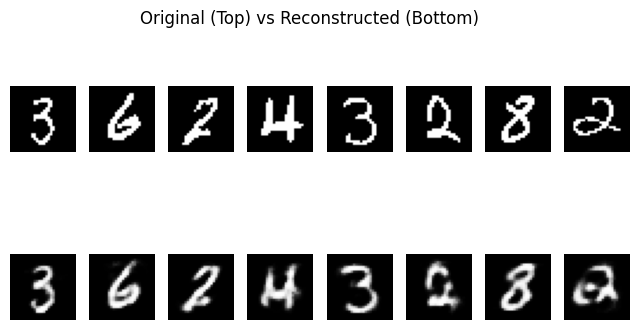

In [17]:
plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 8, i + 1)
    plt.imshow(v[i].view(28, 28), cmap='gray')
    plt.axis('off')
    plt.subplot(2, 8, 8 + i + 1)
    plt.imshow(v_reconstructed[i].view(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle("Original (Top) vs Reconstructed (Bottom)")
plt.show()